In [1]:
import numpy as np
from numpy import linalg as lin
import matplotlib.pyplot as plt
from scipy import signal

global N
N = 20

# define system
x0 = np.array([[1],
               [0]], dtype=float)
A = np.array([[1,1],
              [0,1]], dtype=float)
B = np.array([[0],
              [1]], dtype=float)
C = np.array([[1,0]], dtype=float)
D = np.array([[0]], dtype=float)
sys = [A, B, C, D]

In [2]:
def LQR_DP(sys, rho, Qf):
  global N
  N = 20

  # get system
  A, B, C, D = sys
  Q = C.T@C
  R = rho*np.identity(1)

  # functions
  P_func = lambda P_next: Q + A.T@P_next@A - A.T@P_next@B@lin.inv(R + B.T@P_next@B)@B.T@P_next@A
  K_func = lambda P_next: -lin.inv(R + B.T@P_next@B)@B.T@P_next@A

  # calculate P
  P = [Qf]
  for t in range(N):
    P.append(P_func(P[-1]))
  P.reverse()

  # optimize control (calculate K, u, y)
  K = []
  u_opt = []
  x_opt = []
  x_opt.append(x0)
  y_opt = []
  for t in range(N):
    y_opt.append(C@x_opt[-1])
    K.append(K_func(P[t+1]))
    u_opt.append(K[-1]@x_opt[-1])
    x_opt.append(A@x_opt[-1] + B*u_opt[-1])
  y_opt.append(C@x_opt[-1])
  return y_opt, u_opt, K, P

In [3]:
# MAIN

save_DP = {}
save_DP['rho'], save_DP['J_in'], save_DP['J_out'], save_DP['u'], save_DP['y'], save_DP['K'] = [], [], [], [], [], []

Q = C.T@C
for rho in np.append(np.logspace(-16,16,100),[0.3,10]):
  y_opt, u_opt, K, P = LQR_DP(sys, rho, Q)
  J_in = lin.norm(u_opt)**2
  J_out = lin.norm(y_opt)**2

  # save
  save_DP['rho'].append(rho)
  save_DP['J_in'].append(J_in)
  save_DP['J_out'].append(J_out)
  save_DP['u'].append(u_opt)
  save_DP['y'].append(y_opt)
  save_DP['K'].append(K)

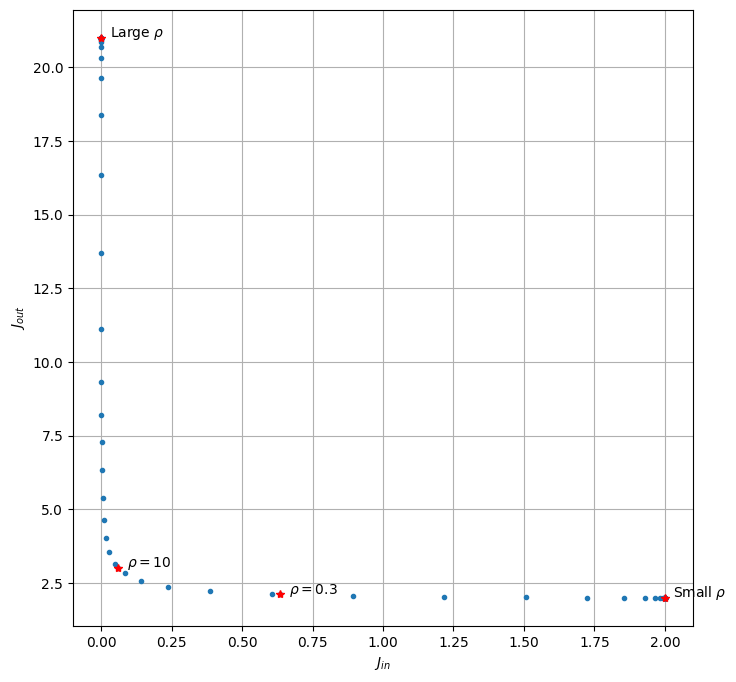

In [4]:
idx3 = save_DP['rho'].index(0.3)
idx10 = save_DP['rho'].index(10)
idxmin = 0
idxmax = -3

plt.figure(figsize=(8,8),dpi=100)
plt.plot(save_DP['J_in'],save_DP['J_out'],'.')
plt.grid()
plt.plot(save_DP['J_in'][idx3],save_DP['J_out'][idx3],'*',color='r')
plt.plot(save_DP['J_in'][idx10],save_DP['J_out'][idx10],'*',color='r')
plt.text(save_DP['J_in'][idx3]+0.03,save_DP['J_out'][idx3]+0.03,r'$\rho=0.3$')
plt.text(save_DP['J_in'][idx10]+0.03,save_DP['J_out'][idx10]+0.03,r'$\rho=10$')
plt.plot(save_DP['J_in'][idxmin],save_DP['J_out'][idxmin],'*',color='r')
plt.plot(save_DP['J_in'][idxmax],save_DP['J_out'][idxmax],'*',color='r')
plt.text(save_DP['J_in'][idxmin]+0.03,save_DP['J_out'][idxmin]+0.03,r'Small $\rho$')
plt.text(save_DP['J_in'][idxmax]+0.03,save_DP['J_out'][idxmax]+0.03,r'Large $\rho$')
plt.xlabel(r'$J_{in}$ ')
plt.ylabel(r'$J_{out}$')
plt.show()

Text(0, 0.5, '$y_t$')

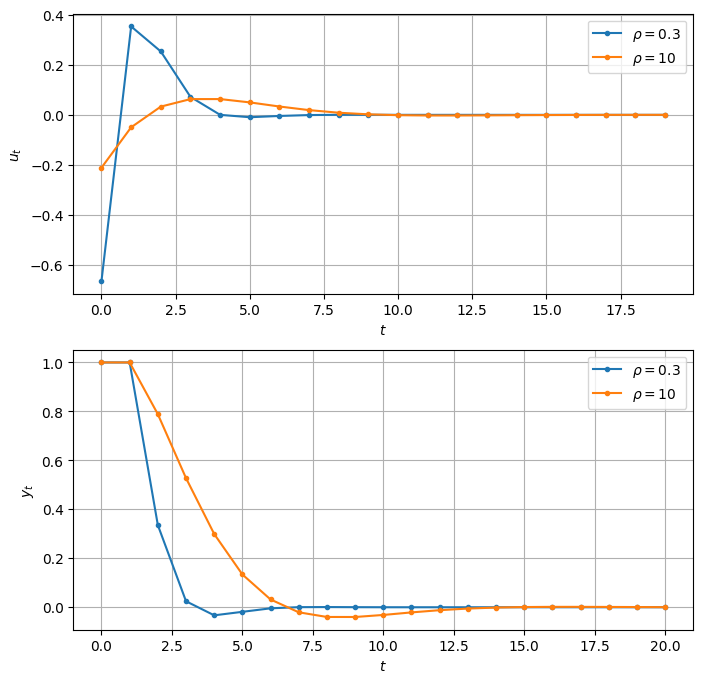

In [5]:
plt.figure(figsize=(8,8), dpi=100)
plt.subplot(2, 1, 1)
plt.plot(range(N),[x[0][0] for x in save_DP['u'][idx3]],'.-',label=r'$\rho = 0.3$')
plt.plot(range(N),[x[0][0] for x in save_DP['u'][idx10]],'.-',label=r'$\rho = 10$')
plt.grid()
plt.legend()
plt.xlabel(r'$t$ ')
plt.ylabel(r'$u_t$')

plt.subplot(2, 1, 2)
plt.plot(range(N+1),[x[0][0] for x in save_DP['y'][idx3]],'.-',label=r'$\rho = 0.3$')
plt.plot(range(N+1),[x[0][0] for x in save_DP['y'][idx10]],'.-',label=r'$\rho = 10$')
plt.grid()
plt.legend()

plt.xlabel(r'$t$ ')
plt.ylabel(r'$y_t$')

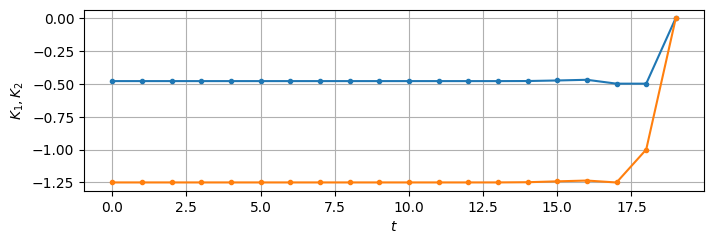

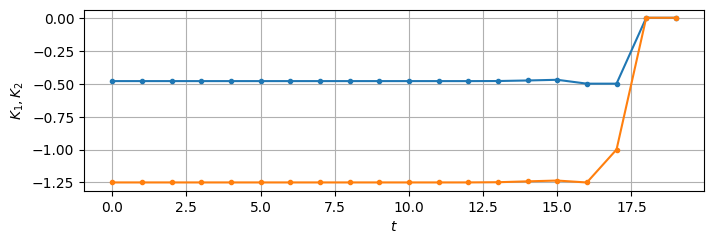

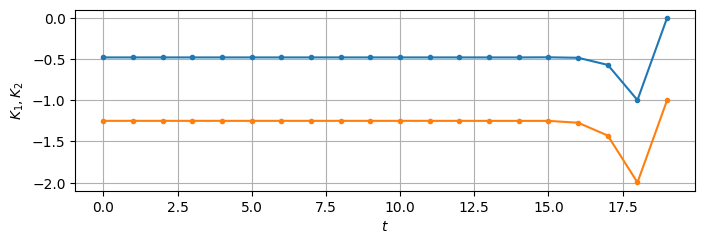

In [6]:
rho = 1
Q_dict = {1: Q, 2: 0*np.identity(len(Q)), 3: 1000*np.identity(len(Q))}
for k in range(1,4):
  _, _, K, _ = LQR_DP(sys, rho, Q_dict[k])
  K_ = np.array([x[0] for x in K])

  plt.figure(figsize=(8,8), dpi=100)
  plt.subplot(3, 1, k)
  plt.plot(range(N),K_[:,0],'.-')
  plt.plot(range(N),K_[:,1],'.-')
  plt.grid()
  plt.xlabel(r'$t$ ')
  plt.ylabel(r'$K_1, K_2$')